### This is a step by step walk through a Pytorch implementation of a gated convolutional neural network (GCNN) from Dauphin et al.'s 2017 paper. I use the wikitext-2 dataset.
### 

# Download and preprocess data

In [ ]:
!pip install spacy==2.2.4

In [ ]:
!pip install fastai==1.0.61

In [ ]:
from fastai import *
from fastai.text import * 

import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import Sampler
from torch.autograd import Variable

import time
import importlib
import seaborn as sns

from GCNN_textfuncs import *

In [ ]:
DATAPATH = Path('/data/GCNN/')

In [ ]:
sns.set() #set graph formatting to seaborn

In [ ]:
#download wikitext-2 dataset and GloVe embeddings
!wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz -P /data
!tar xzf /data/wikitext-2.tgz -C /data
!mv /data/wikitext-2/ /data/GCNN/
!wget http://nlp.stanford.edu/data/glove.6B.zip -P /data/GCNN/
!unzip /data/GCNN/glove.6B.zip -d /data/GCNN/

--2018-12-10 20:33:38--  https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070055 (3.9M) [application/x-tar]
Saving to: '/data/wikitext-2.tgz.1'

wikitext-2.tgz.1    100%[===================>]   3.88M   723KB/s    in 6.5s    

2018-12-10 20:33:45 (610 KB/s) - '/data/wikitext-2.tgz.1' saved [4070055/4070055]

--2018-12-10 20:33:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-12-10 20:33:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP req

In [ ]:
#Do some preprocessing of the data:

#put data into df's w/ columns for 'labels' and 'text'
df_trn = pd.read_csv(DATAPATH/'train.csv',header=None,names=['text'])
df_test = pd.read_csv(DATAPATH/'test.csv',header=None,names=['text'])
df_trn['labels']=0
df_test['labels']=0
df_trn=df_trn[['labels','text']]
df_test=df_test[['labels','text']]

#split data into paragraphs, then remove paragraphs <10 or >300 words
trn_paragraphs=[]
for docnum in range(len(df_trn)):
    trn_paragraphs.extend([x for x in df_trn.iloc[docnum].text.split('\n')])
trn_paragraphs.sort(key=len)
trn_paragraphs=[par for par in trn_paragraphs if (len(par.split(' '))<300 and len(par.split(' '))>10)]#remove paragraphs >300 and <10 words
trn_paragraphs=[par+'xxeos ' for par in trn_paragraphs] #add EOS token at end of each paragraph

test_paragraphs=[]
for docnum in range(len(df_test)):
    test_paragraphs.extend([x for x in df_test.iloc[docnum].text.split('\n')])
test_paragraphs.sort(key=len)
test_paragraphs=[par for par in test_paragraphs if (len(par.split(' '))<300 and len(par.split(' '))>10)]#remove paragraphs >300 and <10 words
test_paragraphs=[par+'xxeos ' for par in test_paragraphs] #add EOS token at end of each paragraph

#put data into csv's
df_trn_par = pd.DataFrame({'text':trn_paragraphs})
df_test_par = pd.DataFrame({'text':test_paragraphs})

df_trn_par['labels']=0
df_test_par['labels']=0
df_trn_par=df_trn_par[['labels','text']]
df_test_par=df_test_par[['labels','text']]

df_trn_par.to_csv(DATAPATH/'train_proc_par2.csv', header=False, index=False)
df_test_par.to_csv(DATAPATH/'test_proc_par2.csv', header=False, index=False)


# Create modeler class

In [ ]:
class modeler():
    def __init__(self,trn_dl,val_dl,module,modelvals=None):
        self.trn_dl, self.val_dl, self.module = trn_dl, val_dl, module
        self.modelvals=modelvals
        self.model=self.module.cuda()
    def model_fit(self):
        samp_n=self.modelvals['samp_n']#the number of iterations in an epoch
        starttime=time.time()
        train_loss_list=[]; val_loss_list=[]
        for epoch in range(0, self.modelvals['epochs']):
            pbar=0#progressbar
            for batch_idx, (data, target) in enumerate(self.trn_dl):
                
                #GRAB MINIBATCH OF INPUTS AND TARGETS, SET OPTIMIZER
                data = Variable(data)
                pbar+=self.modelvals['bs'] #how many iterations have we done in the epoch so far
                if self.modelvals['opttype']=='sgd':
                    self.optimizer = optim.SGD(self.model.parameters(), lr=self.modelvals['lr'], 
                                       momentum=self.modelvals['mom'], weight_decay=self.modelvals['wd'],
                                              nesterov=self.modelvals['nesterov'])
                elif self.modelvals['opttype']=='adam':
                    self.optimizer = optim.Adam(self.model.parameters(), lr=self.modelvals['lr'], 
                                        betas=(self.modelvals['mom'], 0.999))
                self.optimizer.zero_grad()
                
                #FORWARD PASS
                output = self.model(data)
                
                #CALCULATE AND BACKPROP THE LOSS
                loss= output.loss
                loss.backward()
                if self.modelvals['grad_clip']!=0: #gradient clipping
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), self.modelvals['grad_clip'])
                    
                #UPDATE THE WEIGHTS
                self.optimizer.step()
                
                #PRINT OUT TRAINING UPDATES
                train_loss_list.append([epoch,pbar+epoch*samp_n,loss.data.item(),self.modelvals['lr']])
                if batch_idx % 100 == 0:
                    elapsed_time=time.time()-starttime
                    train_update_format_string = 'Train Epoch: {}'
                    train_update_format_string += '\tTotal_its: {:.2f}M [{:.2f}M/{:.2f}M]'
                    train_update_format_string += '\tPercdone: {:.2f}'
                    train_update_format_string += '\tLoss: {:.4f}'
                    train_update_format_string += '\tTime: {:.2f}'
                    train_update_format_string += '\tLR: {:.4f}'
                    train_update_string=train_update_format_string.format(
                            epoch,
                            (pbar + epoch * samp_n) / 1000000, pbar / 1000000, samp_n / 1000000,
                            pbar / samp_n,
                            loss.data.item(),
                            elapsed_time / 60,
                            self.modelvals['lr'])
                    print(train_update_string)
            final_train_loss=loss.data.item()
            
            #NOW TEST VALIDATION SET
            val_loss=[]
            self.model.eval() #important to set to eval mode for testing, so that eg batchnorm and dropout aren't used
            for batch_idx, (data, target) in enumerate(self.val_dl):
                data = Variable(data)
                self.optimizer.zero_grad()
                #ONLY NEED FORWARD PASS... NO BACKPROP
                output = self.model(data)
                loss= output.loss
                output=output.output
                val_loss.append(loss.data.item())
            self.model.train() #set back to training mode
            ave_val_loss=sum(val_loss) / len(val_loss)
            val_update_string='Validation Loss: {:.4f}\tPerp: {:.4f}'.format(
                ave_val_loss,np.exp(ave_val_loss))
            print(val_update_string)
            val_loss_list.append([epoch,ave_val_loss, np.exp(ave_val_loss),elapsed_time/60])
        self.modelvals['val_loss_list']=val_loss_list
        self.modelvals['train_loss_list']=train_loss_list
        print('The end! {:.2f} minutes'.format((time.time()-starttime)/60))

# Set hyperparameters and build embeddings

In [ ]:
#set hyperparameters
bs=50 #batch-size
emb_sz=300 #size of the embedding matrix
nl=4 #number of layers
nh=600 #number hidden units
lr=1 #learning rate
mom=.95 #momentum
wd=5e-5 #weight-decay. Only has effect if opttype==sgd
epochs=50
nesterov=True #Nesterov momentum. only has effect if opttype==sgd
grad_clip=0.07 #gradient clipping value. Set to 0 for no effect. See nn.utils.clip_grad_value_
opttype='sgd' #adam, sgd
k=4 #kernel_width
downbot=20# in the bottleneck layers, how much to decrease channel depth?


In [ ]:
#Use fast.ai to create a TextLMDataBunch object. See http://docs.fast.ai/text.data.html#class-textlmdatabunch
#This tokenizes and numericalizes the data
data_lm = TextLMDataBunch.from_csv(path=DATAPATH, csv_name='train_proc_par2.csv', test='test_proc_par2.csv')
itos=data_lm.train_ds.vocab.itos# the vocab
vs=len(itos)# vs is the length of the vocab

#Grab the numericalized data from the TextLMDataBunch dataset, then construct new custom dataset using LMDataset_GCNN
trn_tokens=[data_lm.train_ds[i][0].data for i in range(len(data_lm.train_ds))]
traindataset=LMDataset_GCNN(trn_tokens)
valid_tokens=[data_lm.valid_ds[i][0].data for i in range(len(data_lm.valid_ds))]
validdataset=LMDataset_GCNN(valid_tokens)

#Create data loaders for training and validation sets
trn_samp=SortishSampler_GCNN(data_length=len(traindataset),key=lambda x:len(traindataset[x][0]), bs=bs)
val_samp=SortSampler_GCNN(validdataset,key=lambda x:len(validdataset[x][0]))
train_loader = data_utils.DataLoader(traindataset, batch_size=bs, collate_fn=pad_collate_GCNN, sampler=trn_samp)
val_loader = data_utils.DataLoader(validdataset, batch_size=bs, collate_fn=pad_collate_GCNN,sampler=val_samp)
samp_n=len(traindataset)
val_samp_n=len(validdataset)

In [ ]:
#put hyperparameters into a dictionary
def get_modelvals():
    modelvals=dict((name,eval(name)) for name in [
        'lr','mom','wd','opttype','epochs','samp_n','val_samp_n',
        'bs','emb_sz','vs', 'nh', 'nl','DATAPATH','nesterov','grad_clip',
        'k','downbot'] )
    return modelvals

modelvals=get_modelvals()

In [ ]:
#grab GloVe embeddings:
#create vocab itos2 from downloaded glove file
words = []
idx = 0
word2idx = {}
vectors = []
with open('/data/GCNN/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vectors.append(line[1:])
itos2=words

#grab the glove embeddings we need, based on the words in our vocab
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)}) #default -1 means its not in glove's itos2
row_m = vectors[-1] #this is default vector... for <unk>
new_w = np.zeros((vs, emb_sz), dtype=np.float32)#initialize new weights to zeros of size (vocab_size,embedding size) e.g. (60002,300)... we're creating an embedding matrix 
for i,w in enumerate(itos): #for index,word in our itos dict, get r index of the word in word2vec's dict. r will be -1 if it doesn't exist in word2vec's dict
    r = stoi2[w]#r index of the word in word2vec's dict
    new_w[i] = vectors[r] if r>=0 else row_m #for our new embedding matrix, set the embedding at the index from our dict equal to the embedding from index r from word2vec's dict
np.save(DATAPATH/'emb_wgts300_proc_par2.npy', new_w) #save the embedding weights

# Run GCNN

In [ ]:
class GLUblock(nn.Module):
    def __init__(self, k, in_c, out_c, downbot):
        super().__init__()
        #only need to change shape of the residual if num_channels changes (i.e. in_c != out_c)
        #[bs,in_c,seq_length]->conv(1,in_c,out_c)->[bs,out_c,seq_length]
        if in_c == out_c:
            self.use_proj=0
        else:
            self.use_proj=1
        self.convresid=nn.utils.weight_norm(nn.Conv2d(in_c, out_c, kernel_size=(1,1)),name='weight',dim=0)
        
        self.leftpad = nn.ConstantPad2d((0,0,k-1,0),0)#(paddingLeft, paddingRight, paddingTop, paddingBottom)

        #[bs,in_c,seq_length+(k-1)]->conv(1,in_c,in_c/downbot)->[bs,in_c/downbot,seq_length+(k-1)]
        self.convx1a = nn.utils.weight_norm(nn.Conv2d(in_c, int(in_c/downbot), kernel_size=(1,1)),name='weight',dim=0)
        self.convx2a = nn.utils.weight_norm(nn.Conv2d(in_c, int(in_c/downbot), kernel_size=(1,1)),name='weight',dim=0)
        #[bs,in_c/downbot,seq_length+(k-1)]->conv(k,in_c/downbot,in_c/downbot)->[bs,in_c/downbot,seq_length]
        self.convx1b = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), int(in_c/downbot), kernel_size=(k,1)),name='weight',dim=0)
        self.convx2b = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), int(in_c/downbot), kernel_size=(k,1)),name='weight',dim=0)
        #[bs,in_c/downbot,seq_length]->conv(1,in_c/downbot,out_c)->[bs,out_c,seq_length]
        self.convx1c = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), out_c, kernel_size=(1,1)),name='weight',dim=0)
        self.convx2c = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), out_c, kernel_size=(1,1)),name='weight',dim=0)

    def forward(self, x):
        residual = x
        if self.use_proj==1:# if in_c != out_c, need to change size of residual
            residual=self.convresid(residual)
        x=self.leftpad(x) # [bs,in_c,seq_length+(k-1),1]
        x1 = self.convx1c(self.convx1b(self.convx1a(x))) # [bs,out_c,seq_length,1]
        x2 = self.convx2c(self.convx2b(self.convx2a(x))) # [bs,out_c,seq_length,1]
        x2 = torch.sigmoid(x2)
        x=torch.mul(x1,x2) # [bs,out_c,seq_length,1]
        return x+residual

In [ ]:
class GCNNmodel(nn.Module):
    def __init__(self, vs, emb_sz, k, nh, nl,downbot):
    #def __init__(self, vs, emb_sz, k, nh, nl,dw,cutoffs):
        super().__init__()
        
        self.embed = nn.Embedding(vs, emb_sz)
        
        self.inlayer=GLUblock(k,emb_sz,nh,downbot)
        self.GLUlayers=self.make_GLU_layers(k,nh,nl,downbot)
        self.out=nn.AdaptiveLogSoftmaxWithLoss(nh, vs, cutoffs=[round(vs/25),round(vs/5)],div_value=4)

    def make_GLU_layers(self, k, nh, nl, downbot):
        layers = [GLUblock(k, nh, nh, downbot) for i in range(nl)]
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        target=x[1:,:]
        target=target.contiguous().view(target.size()[0]*target.size()[1])#[seq_length*bs,out_c]
        x=x[:-1,:]
        
        #first block
        x = self.embed(torch.t(x)) # x -> [seq_length,bs] -> [bs,seq_length] -> [bs,seq_length,emb_sz] ... i.e. transpose 1st
        x=torch.transpose(x, 1, 2) #[bs,emb_sz,seq_length]    
        x = x.unsqueeze(3)  # [bs,emb_sz,seq_length,1]
        x=self.inlayer(x) #[bs,nh,seq_length,1]
             
        #residual GLU blocks
        x=self.GLUlayers(x) # [bs,nh,seq_length,1]
        
        #out
        x=torch.squeeze(x,3) #[bs,out_c,seq_length]
        x=torch.transpose(x, 1, 2) #[bs,seq_length,out_c]
        x=torch.transpose(x, 0, 1) #[seq_length,bs,out_c]
        x=x.contiguous().view(-1,x.size()[2])#[seq_length*bs,out_c]
        outta=self.out(x,target)
        
        return    outta

In [ ]:
#create GCNN 
GCNNnet=modeler(train_loader,val_loader,
                           GCNNmodel(vs, emb_sz, k, nh, nl, downbot),modelvals)
print(GCNNnet.model)

GCNNmodel(
  (embed): Embedding(25005, 300)
  (inlayer): GLUblock(
    (convresid): Conv2d(300, 600, kernel_size=(1, 1), stride=(1, 1))
    (leftpad): ConstantPad2d(padding=(0, 0, 3, 0), value=0)
    (convx1a): Conv2d(300, 15, kernel_size=(1, 1), stride=(1, 1))
    (convx2a): Conv2d(300, 15, kernel_size=(1, 1), stride=(1, 1))
    (convx1b): Conv2d(15, 15, kernel_size=(4, 1), stride=(1, 1))
    (convx2b): Conv2d(15, 15, kernel_size=(4, 1), stride=(1, 1))
    (convx1c): Conv2d(15, 600, kernel_size=(1, 1), stride=(1, 1))
    (convx2c): Conv2d(15, 600, kernel_size=(1, 1), stride=(1, 1))
  )
  (GLUlayers): Sequential(
    (0): GLUblock(
      (convresid): Conv2d(600, 600, kernel_size=(1, 1), stride=(1, 1))
      (leftpad): ConstantPad2d(padding=(0, 0, 3, 0), value=0)
      (convx1a): Conv2d(600, 30, kernel_size=(1, 1), stride=(1, 1))
      (convx2a): Conv2d(600, 30, kernel_size=(1, 1), stride=(1, 1))
      (convx1b): Conv2d(30, 30, kernel_size=(4, 1), stride=(1, 1))
      (convx2b): Conv2d(

In [ ]:
#load the glove-vectors into the model
new_w=np.load(DATAPATH/'emb_wgts300_proc_par2.npy') #load embedding weights
GCNNnet.model.embed.weight.data=torch.FloatTensor(new_w).cuda()

In [ ]:
GCNNnet.model_fit()

Train Epoch: 0	Total_its: 0.00M [0.00M/0.01M]	Percdone: 0.00	Loss: 8.6694	Time: 0.02	LR: 1.0000
Train Epoch: 0	Total_its: 0.01M [0.01M/0.01M]	Percdone: 0.36	Loss: 84.8770	Time: 0.41	LR: 1.0000
Train Epoch: 0	Total_its: 0.01M [0.01M/0.01M]	Percdone: 0.72	Loss: 58.1936	Time: 0.75	LR: 1.0000
Validation Loss: 19.4324	Perp: 275028850.7105
Train Epoch: 1	Total_its: 0.01M [0.00M/0.01M]	Percdone: 0.00	Loss: 17.9454	Time: 1.33	LR: 1.0000
Train Epoch: 1	Total_its: 0.02M [0.01M/0.01M]	Percdone: 0.36	Loss: 10.2991	Time: 1.72	LR: 1.0000
Train Epoch: 1	Total_its: 0.02M [0.01M/0.01M]	Percdone: 0.72	Loss: 5.0886	Time: 2.28	LR: 1.0000
Validation Loss: 9.0299	Perp: 8348.8260
Train Epoch: 2	Total_its: 0.03M [0.00M/0.01M]	Percdone: 0.00	Loss: 8.2724	Time: 2.79	LR: 1.0000
Train Epoch: 2	Total_its: 0.03M [0.01M/0.01M]	Percdone: 0.36	Loss: 7.9598	Time: 3.17	LR: 1.0000
Train Epoch: 2	Total_its: 0.04M [0.01M/0.01M]	Percdone: 0.72	Loss: 4.8604	Time: 3.56	LR: 1.0000
Validation Loss: 6.1673	Perp: 476.9110
Train E

Validation Loss: 4.6390	Perp: 103.4425
Train Epoch: 25	Total_its: 0.35M [0.00M/0.01M]	Percdone: 0.00	Loss: 4.3723	Time: 34.09	LR: 1.0000
Train Epoch: 25	Total_its: 0.35M [0.01M/0.01M]	Percdone: 0.36	Loss: 4.7923	Time: 34.43	LR: 1.0000
Train Epoch: 25	Total_its: 0.36M [0.01M/0.01M]	Percdone: 0.72	Loss: 3.5208	Time: 34.81	LR: 1.0000
Validation Loss: 4.6359	Perp: 103.1180
Train Epoch: 26	Total_its: 0.36M [0.00M/0.01M]	Percdone: 0.00	Loss: 4.3438	Time: 35.38	LR: 1.0000
Train Epoch: 26	Total_its: 0.37M [0.01M/0.01M]	Percdone: 0.36	Loss: 4.0997	Time: 35.74	LR: 1.0000
Train Epoch: 26	Total_its: 0.37M [0.01M/0.01M]	Percdone: 0.72	Loss: 4.1723	Time: 36.23	LR: 1.0000
Validation Loss: 4.5227	Perp: 92.0815
Train Epoch: 27	Total_its: 0.38M [0.00M/0.01M]	Percdone: 0.00	Loss: 4.1727	Time: 36.76	LR: 1.0000
Train Epoch: 27	Total_its: 0.38M [0.01M/0.01M]	Percdone: 0.36	Loss: 4.7655	Time: 37.13	LR: 1.0000
Train Epoch: 27	Total_its: 0.39M [0.01M/0.01M]	Percdone: 0.72	Loss: 4.1541	Time: 37.53	LR: 1.0000
Va

Train Epoch: 49	Total_its: 0.69M [0.01M/0.01M]	Percdone: 0.72	Loss: 5.2233	Time: 67.30	LR: 1.0000
Validation Loss: 4.7790	Perp: 118.9911
The end! 67.84 minutes


In [ ]:
epoch_list,loss_list,perp_list,time_list=zip(*GCNNnet.modelvals['val_loss_list'])

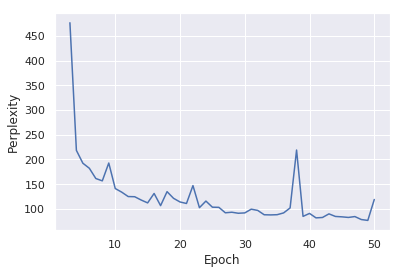

In [ ]:
plt.plot(list(range(3,51)),perp_list[2:])
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()